In [504]:
import os
import numpy as np
import pandas as pd

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [505]:
def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Calculate the R-squared score between the true values and predicted values.

    Parameters:
        y_true: The true target values.
        y_pred: The predicted target values.

    Returns:
        The R-squared score.
    """
    mean_y_true = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y_true) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1.0 - (ss_residual / ss_total)
    return r2

In [506]:
def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Calculate the mean squared error between the true values and predicted values.

    Parameters:
        y_true: The true target values.
        y_pred: The predicted target values.

    Returns:
        The mean squared error value.
    """
    return np.mean((y_true - y_pred) ** 2)

## Boston house prices

Feature description:

0. **CRIM** - per capita crime rate by town
1. **ZN** - proportion of residential land zoned for lots over 25,000 sq.ft.
2. **INDUS** - proportion of non-retail business acres per town
3. **CHAS** - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
4. **NOX** - nitric oxides concentration (parts per 10 million)
5. **RM** - average number of rooms per dwelling
6. **AGE** - proportion of owner-occupied units built prior to 1940
7. **DIS** - weighted distances to ﬁve Boston employment centers
8. **RAD** - index of accessibility to radial highways
9. **TAX** - full-value property-tax rate per \$10,000
10. **PTRATIO** - pupil-teacher ratio by town
12. **B** - 1000(Bk−0.63) 2 where Bk is the proportion of blacks by town
13. **LSTAT** - % lower status of the population
14. **MEDV** - Median value of owner-occupied homes in \$1000s. We can see that the input attributes have a mixture of units.


In [507]:
# dataset source: https://www.kaggle.com/datasets/vikrishnan/boston-house-prices

feature_names = ("CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV")
dataset = pd.read_csv(os.path.join("data", "boston_house_prices.csv"), header=None, delimiter=r"\s+", names=feature_names)
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [508]:
dataset.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


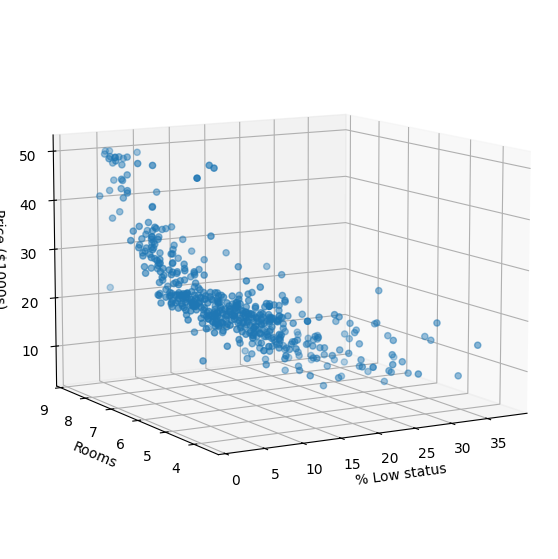

In [509]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.scatter3D(dataset["LSTAT"], dataset["RM"], dataset["MEDV"])
ax.azim = -120
ax.dist = 10
ax.elev = 10

ax.set_xlabel("% Low status")
ax.set_ylabel("Rooms")
ax.set_zlabel("Price ($1000s)");

In [510]:
def build_features(data: pd.DataFrame) -> np.ndarray:
    # Мій найкращій результат. Комбінувались різні фічери, проводив проводив стартазацію (z-score) і логаріфмічну трансформацію.
    # Отримані результати:
    # R2: 0.8629120707714403
    # MSE: 11.572902139842846

    data['PT_LOG'] = (data['PTRATIO']).transform(np.log)
    data['INDUS_LOG'] = (data['INDUS']).transform(np.log)
    data['TAX_LOG'] = (data['TAX']).transform(np.log)
    data['LSTAT_LOG'] = (data['LSTAT']).transform(np.log)
    data['LSTAT_STD'] = (data['LSTAT'] - data['LSTAT'].mean())/(data['LSTAT'].std())
    data['RM_STD'] = (data['RM'] - data['RM'].mean())/(data['RM'].std())
    data['DIS_STD'] = (data['DIS']).transform(np.log)
    data['RAD_LOG'] = (data['RAD'] + 1).transform(np.log)

    result = np.concatenate(
        [data[["CRIM", "ZN", "CHAS", "NOX", "RM_STD", "DIS_STD", "RAD", "TAX_LOG", "PT_LOG", "LSTAT_LOG", "B", "AGE", "INDUS_LOG"]].values,
        (data["LSTAT_STD"] * data["RM_STD"]).values[..., None],
        (data["DIS"] * data["RAD"]).values[..., None],
        (data["NOX"] * data["DIS"]).values[..., None],
        (data["LSTAT_STD"] * data["DIS_STD"]).values[..., None],
        (data["LSTAT_STD"] * data["RAD_LOG"]).values[..., None]],
        1
    )

    # print(data["TAX_SC"].head())
    # print(data["LSTAT_LOG"].head())
    return result

# Prepare dataset
x = build_features(dataset)
y = dataset["MEDV"].values

# Fit the model
model = sm.OLS(y, sm.add_constant(x)).fit()

# Check model performance
print("Coeffs:", model.params)
print("R2:", model.rsquared)
print("MSE:", mean_squared_error(y, model.fittedvalues))
print(model.summary())

Coeffs: [ 1.30717706e+02 -1.61092358e-01  1.09445969e-02  1.16912416e+00
 -3.07298339e+01  1.95389554e+00 -1.64947109e+01  4.06029743e-01
 -4.29024750e+00 -1.21782775e+01 -8.19869066e+00  3.59615211e-03
 -4.43630999e-02 -1.09162869e+00 -1.67942824e+00 -3.46186352e-02
  5.64299931e+00  3.23104945e+00 -1.57703692e+00]
R2: 0.8629120707714403
MSE: 11.572902139842846
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     170.3
Date:                Tue, 30 Jan 2024   Prob (F-statistic):          7.93e-197
Time:                        13:03:58   Log-Likelihood:                -1337.5
No. Observations:                 506   AIC:                             2713.
Df Residuals:                     487   BIC:                             2793.
Df 

In [511]:
def build_features(data: pd.DataFrame) -> np.ndarray:
    # Базові features, які даються в датасеті. MEDV виключено зі списку. Були отримані такі дані:
    # R2: 0.7406426641094094
    # MSE: 21.894831181729202

    result = data[["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]].values

    return result

# Prepare dataset
x = build_features(dataset)
y = dataset["MEDV"].values

# Fit the model
model = sm.OLS(y, sm.add_constant(x)).fit()

# Check model performance
print("Coeffs:", model.params)
print("R2:", model.rsquared)
print("MSE:", mean_squared_error(y, model.fittedvalues))
print(model.summary())

Coeffs: [ 3.64594884e+01 -1.08011358e-01  4.64204584e-02  2.05586264e-02
  2.68673382e+00 -1.77666112e+01  3.80986521e+00  6.92224640e-04
 -1.47556685e+00  3.06049479e-01 -1.23345939e-02 -9.52747232e-01
  9.31168327e-03 -5.24758378e-01]
R2: 0.7406426641094095
MSE: 21.894831181729206
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 30 Jan 2024   Prob (F-statistic):          6.72e-135
Time:                        13:03:58   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covar

In [512]:
def build_features(data: pd.DataFrame) -> np.ndarray:
    # Базові features, які даються в датасеті. MEDV виключено зі списку. Була оцінена вага фичєров і видалені "INDUS" і "AGE".
    # Вони майже не впливають на результати (навіть трошки гірше). Були отримані такі дані:
    # R2: 0.7405822802569574
    # MSE: 21.899928759752203

    result = data[["CRIM", "ZN", "CHAS", "NOX", "RM", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]].values

    return result

# Prepare dataset
x = build_features(dataset)
y = dataset["MEDV"].values

# Fit the model
model = sm.OLS(y, sm.add_constant(x)).fit()

# Check model performance
print("Coeffs:", model.params)
print("R2:", model.rsquared)
print("MSE:", mean_squared_error(y, model.fittedvalues))
print(model.summary())

Coeffs: [ 3.63411450e+01 -1.08413345e-01  4.58449292e-02  2.71871630e+00
 -1.73760234e+01  3.80157884e+00 -1.49271146e+00  2.99608454e-01
 -1.17779735e-02 -9.46524570e-01  9.29084477e-03 -5.22553457e-01]
R2: 0.7405822802569575
MSE: 21.8999287597522
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Tue, 30 Jan 2024   Prob (F-statistic):          5.54e-137
Time:                        13:03:58   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust   

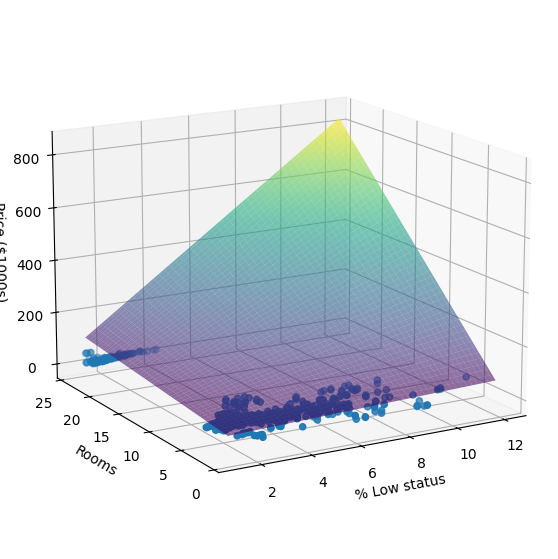

In [513]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.scatter3D(dataset["DIS"], dataset["RAD"], dataset["MEDV"], "r")
ax.azim = -120
ax.dist = 10
ax.elev = 15

x1 = np.linspace(dataset["DIS"].min(), dataset["DIS"].max(), 100)
x2 = np.linspace(dataset["RAD"].min(), dataset["RAD"].max(), 100)
x1, x2 = np.meshgrid(x1, x2)
x3 = model.params[0] + x1 * model.params[1] + x2 * model.params[2] + x1 * x2 * model.params[3]
ax.plot_surface(x1, x2, x3, cmap="viridis", alpha=0.6)

ax.set_xlabel("% Low status")
ax.set_ylabel("Rooms")
ax.set_zlabel("Price ($1000s)");

### Conclusion

Висновки про **boston_house_prices** пишіть в цьому блоці.

"""
Якщо я вірно зрозумів завдання:

1. Параметри 'INDUS' і 'AGE' майже не мають значення на точніть аналізу. Параметри 'CHAS', 'ZN', 'B' мають невеликий вплив.
2. Найбільше значення мають параметри і їх комбінації: 'LSTAT', 'RM', 'DIST', 'RAD', 'NOX'
3. Найменше значення MSE i найкращій R2:
# R2: 0.8629120707714403
# MSE: 11.572902139842846

"""